# Simulasi Android Track Tranportation Polution

Data berasal dari random historical.

Menggunakan LSTM: 
LSTM (Long Short-Term Memory) adalah jenis arsitektur jaringan saraf tiruan yang termasuk dalam kategori Recurrent Neural Networks (RNN). LSTM dirancang khusus untuk mengatasi masalah yang sering dihadapi oleh RNN standar, yaitu masalah vanishing gradient dan exploding gradient, yang membuat RNN sulit untuk mempelajari dependensi jangka panjang dalam data sekuensial.

Daftar isi:
- [model LSTM](#model-lstm)
- [Evaluasi Model](evaluasi-model)
- [Simulasi input dari Android](#simulasi-input-android)

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
def generate_historical_data(n_samples=100000):
    activities = ['walking', 'cycling', 'bus', 'car', 'motorcycle']
    data = []
    for _ in range(n_samples):
        activity = np.random.choice(activities)
        if activity == 'walking':
            acc_x = np.random.normal(0, 0.5)
            acc_y = np.random.normal(0, 0.5)
            acc_z = np.random.normal(9.8, 0.3)
            speed = np.random.uniform(0, 2)
        elif activity == 'cycling':
            acc_x = np.random.normal(0, 1)
            acc_y = np.random.normal(0, 1)
            acc_z = np.random.normal(9.8, 0.5)
            speed = np.random.uniform(2, 6)
        elif activity == 'bus':
            acc_x = np.random.normal(0, 0.3)
            acc_y = np.random.normal(0, 0.3)
            acc_z = np.random.normal(9.8, 0.1)
            speed = np.random.uniform(5, 15)
        elif activity == 'car':
            acc_x = np.random.normal(0, 0.2)
            acc_y = np.random.normal(0, 0.2)
            acc_z = np.random.normal(9.8, 0.1)
            speed = np.random.uniform(10, 30)
        else:  # motorcycle
            acc_x = np.random.normal(0, 0.8)
            acc_y = np.random.normal(0, 0.8)
            acc_z = np.random.normal(9.8, 0.4)
            speed = np.random.uniform(8, 25)
        data.append([acc_x, acc_y, acc_z, speed, activity])
    return pd.DataFrame(data, columns=['acc_x', 'acc_y', 'acc_z', 'speed', 'activity'])

In [3]:
# Generate data
df = generate_historical_data()

# Prepare data
X = df[['acc_x', 'acc_y', 'acc_z', 'speed']]
y = df['activity']

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Reshape input for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [7]:
# Convert labels to categorical
y_train_cat = to_categorical(pd.Categorical(y_train).codes)
y_test_cat = to_categorical(pd.Categorical(y_test).codes)

## Model LSTM

In [10]:
# Buat model LSTM
model = Sequential([
    Input(shape=(1, 4)), 
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train model
history = model.fit(X_train_reshaped, y_train_cat, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6325 - loss: 0.8098 - val_accuracy: 0.8945 - val_loss: 0.2436
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8761 - loss: 0.2963 - val_accuracy: 0.9029 - val_loss: 0.2246
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8885 - loss: 0.2653 - val_accuracy: 0.9051 - val_loss: 0.2200
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8873 - loss: 0.2593 - val_accuracy: 0.9072 - val_loss: 0.2099
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8932 - loss: 0.2463 - val_accuracy: 0.9070 - val_loss: 0.2127
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8919 - loss: 0.2492 - val_accuracy: 0.9056 - val_loss: 0.2130
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8964 - loss: 0.2367 - val_accuracy: 0.9062 - val_loss: 0.2118
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8970 - loss: 0.2353 -

## Evaluasi Model

In [12]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9007


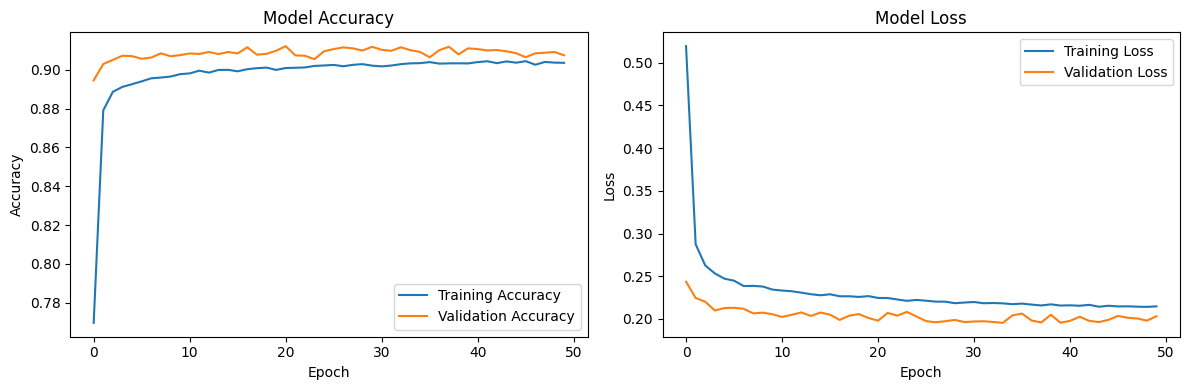

In [13]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi model dan confusion matrix
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


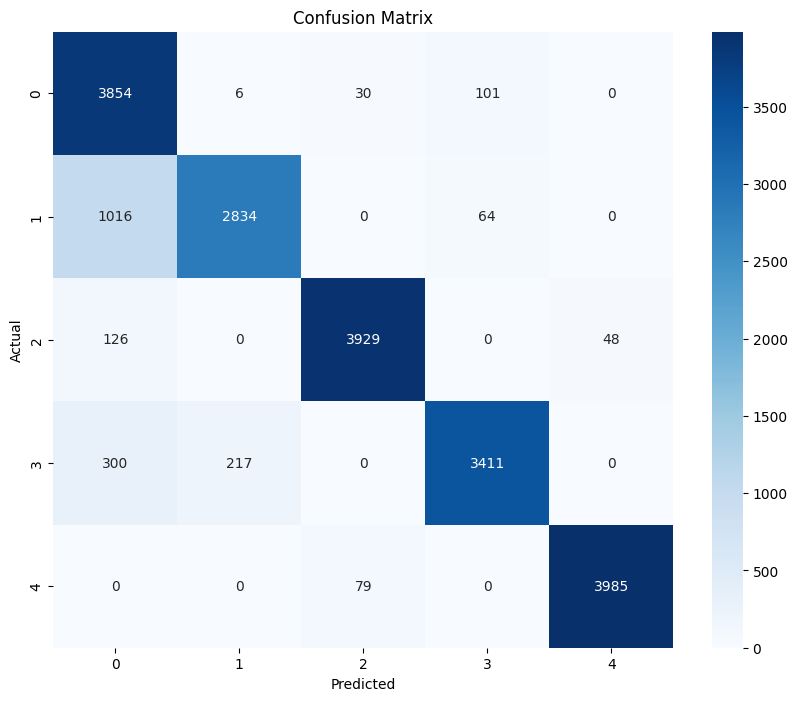

In [21]:
# Evaluasi model dan confusion matrix
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Save model and scaler
model.save('transport_mode_model.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Simulasi Input Android

In [25]:
def process_android_input(acc_x, acc_y, acc_z, speed):
    # Mengubah input menjadi DataFrame
    feature_names = ['acc_x', 'acc_y', 'acc_z', 'speed']
    input_data = pd.DataFrame([[acc_x, acc_y, acc_z, speed]], columns=feature_names)
    
    print("Raw input:", input_data)
    
    # Scaling input
    input_scaled = scaler.transform(input_data)
    print("Scaled input:", input_scaled)
    
    # Reshape untuk LSTM
    input_reshaped = input_scaled.reshape((1, 1, 4))
    
    # Prediksi
    prediction = model.predict(input_reshaped)
    print("Model output:", prediction)
    
    activities = ['walking', 'cycling', 'bus', 'car', 'motorcycle']
    predicted_index = np.argmax(prediction)
    predicted_activity = activities[predicted_index]
    confidence = prediction[0][predicted_index]
    
    # Estimasi pengurangan karbon (contoh sederhana)
    carbon_reduction = 0
    if predicted_activity in ['walking', 'cycling']:
        carbon_reduction = 0.5  # Misalnya, 0.5 kg CO2 per perjalanan
    elif predicted_activity == 'bus':
        carbon_reduction = 0.2  # Misalnya, 0.2 kg CO2 dibandingkan dengan mobil
    
    return {
        'predicted_activity': predicted_activity,
        'confidence': confidence,
        'carbon_reduction': carbon_reduction
    }

## Simulasi Input Android

In [26]:
# Input manual
inputs = {
    'walk': {'acc_x': 0.1, 'acc_y': 0.2, 'acc_z': 9.8, 'speed': 1.5},
    'cycle': {'acc_x': 0.3, 'acc_y': 0.4, 'acc_z': 9.7, 'speed': 4.0},
    'bus': {'acc_x': 0.05, 'acc_y': 0.05, 'acc_z': 9.9, 'speed': 10.0},
    'car': {'acc_x': 0.02, 'acc_y': 0.02, 'acc_z': 9.95, 'speed': 20.0},
    'motorcycle': {'acc_x': 0.4, 'acc_y': 0.4, 'acc_z': 9.6, 'speed': 15.0}
}

for activity, input_data in inputs.items():
    print(f"\nProcessing {activity}:")
    result = process_android_input(**input_data)
    print(f"{activity.capitalize()} - Predicted Activity: {result['predicted_activity']}")
    print(f"{activity.capitalize()} - Confidence: {result['confidence']:.2%}")
    print(f"{activity.capitalize()} - Estimated Carbon Reduction: {result['carbon_reduction']} kg CO2")


Processing walk:
Raw input:    acc_x  acc_y  acc_z  speed
0    0.1    0.2    9.8    1.5
Scaled input: [[ 0.16054031  0.31818619 -0.00157104 -1.08103696]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Model output: [[2.3647081e-14 2.4484722e-13 2.5873867e-06 5.6377057e-17 9.9999738e-01]]
Walk - Predicted Activity: motorcycle
Walk - Confidence: 100.00%
Walk - Estimated Carbon Reduction: 0 kg CO2

Processing cycle:
Raw input:    acc_x  acc_y  acc_z  speed
0    0.3    0.4    9.7    4.0
Scaled input: [[ 0.47237189  0.63144806 -0.31178103 -0.77318952]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model output: [[2.7328508e-02 5.5070283e-15 9.7267139e-01 2.1065413e-08 1.0471371e-07]]
Cycle - Predicted Activity: bus
Cycle - Confidence: 97.27%
Cycle - Estimated Carbon Reduction: 0.2 kg CO2

Processing bus:
Raw input:    acc_x  acc_y  acc_z  speed
0   0.05   0.05    9.9   10.0
Scaled input: [[ 0.08258242  0.08323979  0.30863895 -0.03435566]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model output: [[5.7894123e-01 